# RNN. Actividad realizada por Angela Cristina Villate
UNIR - MIA, junio del 2024


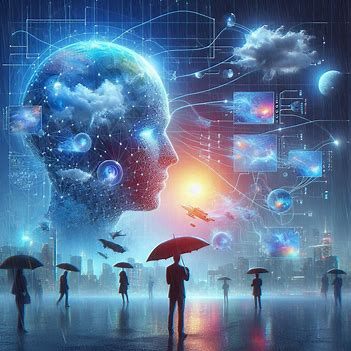

### Introducción

El propósito de este ejercicio es implementar la arquitectura de RNN (redes neuronales recurrentes) para analizar datos recolectados a lo largo del tiempo (series de tiempo). El dataset utilizado es "Daily - Min Temperatures", que contiene 3651 registros de temperatura desde enero de 1981 hasta diciembre de 1990. Las series de tiempo requieren la información de estados anteriores para predecir su comportamiento futuro. En este caso, el objetivo es entrenar un modelo de deep learning capaz de predecir la temperatura basándose en datos históricos.

Para lograr este objetivo, se han desarrollado y comparado dos modelos de redes neuronales recurrentes.

No es un dato menor que el fenómeno a analizar sea el de la temperatura, el cual es un evento difícil de predecir con precisión debido a la gran cantidad de variables ambientales que influyen en ella. A diferencia de otras series de tiempo como la inflación, los datos bursátiles o las series lingüísticas, la temperatura depende de factores múltiples y complejos. Por lo tanto, los datos históricos por sí solos no son suficientes; se necesita una comprensión más amplia de los factores ambientales que terminan por impactarla.

Así, aunque las secuencias de datos puedan ser procesadas por el modelo, esta única entrada no garantiza predicciones precisas. Los modelos de predicción que requieren secuencias de datos con mucha información deben tratarse como series irregulares o fenómenos complejos en lugar de series regulares o fenómenos simples.

A continuación, se presenta el proceso de trabajo y los resultados obtenidos de los modelos desarrollados, con una reflexión sobre el análisis de los datos y sus implicaciones.

## 1. Carga y lectura de datos

Se siguieron casi todos los pasos de la guía, sin embargo debido a que l ejercicio fue desarrollado desde mi entorno personal de trabajo, fue necesario acudir a request para lograr descargar los datos en una ruta local

🖥️🖥️🖥️🖥️ 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import requests

# URL del archivo que deseas descargar
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

# Ruta donde deseas guardar el archivo
file_path = "C:\\Users\\villa\\daily-min-temperatures.csv"

# Realizar la solicitud GET
response = requests.get(url)

# Verificar que la solicitud fue exitosa
if response.status_code == 200:
    # Abrir el archivo en modo de escritura binaria y guardar el contenido
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"Archivo guardado en {file_path}")
else:
    print(f"Error al descargar el archivo: {response.status_code}")

Archivo guardado en C:\Users\villa\daily-min-temperatures.csv


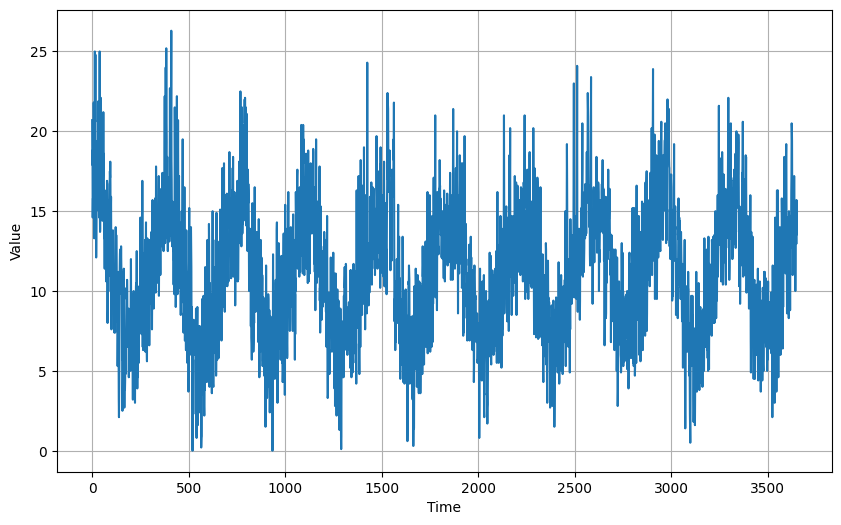

In [4]:

import csv
time_step = []
temps = []

with open("C:\\Users\\villa\\daily-min-temperatures.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

💡💡💡

### Interpretación preeliminar del dataset

La gráfica muestra el comportamiento de la temperatura en una serie temporal. Es notorio que nos enfrentamos a datos que no son del todo regulares o cuya regularidad es difícil de determinar; sin embargo, para contar con una mayor caracterización de los datos se realizaron las visualizaciones que se presentan a continuación.

💡💡💡

In [6]:
import pandas as pd
# Leer el archivo CSV en un DataFrame de pandas
data = pd.read_csv(file_path, parse_dates=['Date'])

# Visualizar el DataFrame para verificar los datos
print(data.head())

# Extraer los valores necesarios
time_step = np.arange(len(data))  # Generar un array de pasos de tiempo
temps = data['Temp'].to_numpy()  # Convertir la columna de temperaturas a un array de numpy


        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv(file_path)

print("Primeros 15 datos:")
print(df.head(15))

print("\nÚltimos 15 datos:")
print(df.tail(15))

Primeros 15 datos:
          Date  Temp
0   1981-01-01  20.7
1   1981-01-02  17.9
2   1981-01-03  18.8
3   1981-01-04  14.6
4   1981-01-05  15.8
5   1981-01-06  15.8
6   1981-01-07  15.8
7   1981-01-08  17.4
8   1981-01-09  21.8
9   1981-01-10  20.0
10  1981-01-11  16.2
11  1981-01-12  13.3
12  1981-01-13  16.7
13  1981-01-14  21.5
14  1981-01-15  25.0

Últimos 15 datos:
            Date  Temp
3635  1990-12-17  13.9
3636  1990-12-18  17.2
3637  1990-12-19  14.7
3638  1990-12-20  15.4
3639  1990-12-21  13.1
3640  1990-12-22  13.2
3641  1990-12-23  13.9
3642  1990-12-24  10.0
3643  1990-12-25  12.9
3644  1990-12-26  14.6
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0


🛎️🛎️🛎️

### ¿Están balanceados los datos?

En el siguiente paso, verificamos que hubiera la misma cantidad de datos para cada año. De este modo, pudimos asegurarnos de que los datos estuvieran equilibrados al tomar el año como unidad de análisis.

Además, calculamos la media de la temperatura para cada año. Estos datos indican que, al analizar la temperatura año tras año, ninguna serie se repite, aunque existen valores cercanos, como durante el periodo de 1986 y 1987. De esto se puede concluir que, para generar predicciones precisas sobre el clima, probablemente se necesiten series de tiempo mucho más largas para poder establecer patrones de análisis confiables.

🛎️🛎️🛎️


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

yearly_data = df.groupby('Year').agg(
    Avg_Temp=('Temp', 'mean'),
    Data_Count=('Temp', 'size')
).reset_index()

# Mostrar los datos agrupados por año
print(yearly_data)

   Year   Avg_Temp  Data_Count
0  1981  11.517260         365
1  1982  10.783562         365
2  1983  11.187397         365
3  1984  10.591781         365
4  1985  11.137534         365
5  1986  10.803288         365
6  1987  10.853151         365
7  1988  11.972055         365
8  1989  11.261918         365
9  1990  11.669589         365


📉📉📉

### Gráfica de medias

A continuación, se presentan gráficamente las medias de la temperatura calculadas para cada año.

📉📉📉

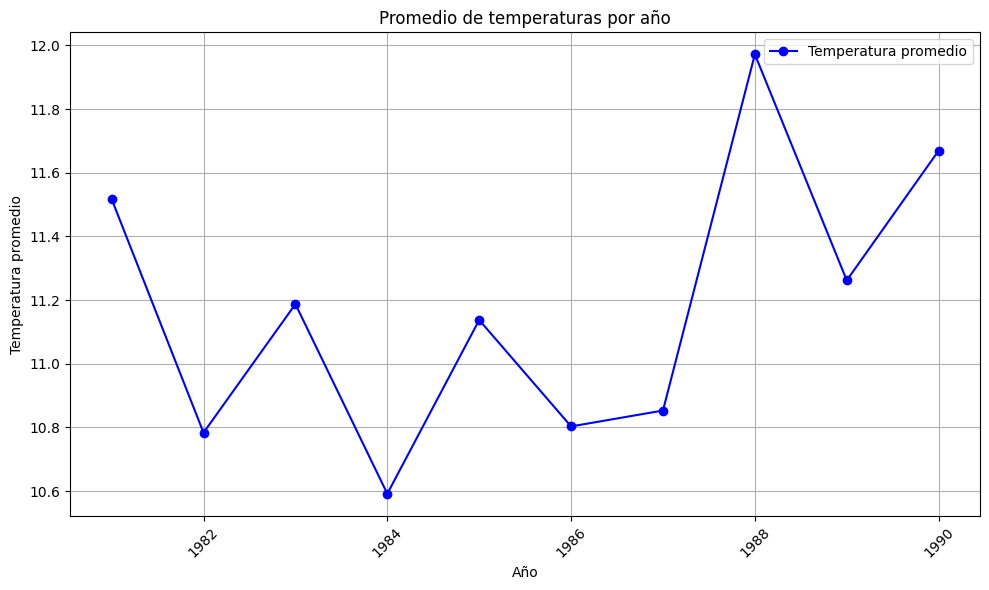

In [10]:
import matplotlib.pyplot as plt
# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(yearly_data['Year'], yearly_data['Avg_Temp'], marker='o', linestyle='-', color='b', label='Temperatura promedio')
plt.title('Promedio de temperaturas por año')
plt.xlabel('Año')
plt.ylabel('Temperatura promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Normalización de datos

En esta fase se realizaron tres procesos, a saber:
    
 📉📉**Normalización de los datos:** Este proceso de escalado permite que todos los valores estén dentro del mismo rango, facilitando el análisis y procesamiento por parte del modelo.
 
📉📉**Creación de ventanas de tiempo:** Dado que se analizan series de tiempo, los datos se han agrupado en secuencias de entrada y etiquetas para optimizar el rendimiento del modelo.
Agrupación de secuencias de entrada: Cada secuencia se ha agrupado en intervalos de 30 días, proporcionando una medida mensual que permite capturar patrones temporales relevantes.

📉📉**Visualización de las ventanas de tiempo:** para tener una mayor claridad sobre la forma en la que trabajan las ventanas de tiempo se ha generado una visualización que nos permita comprender las características de las cadenas de datos que recibirá el modelo. La visualización de los datos por día, corrobora la observación de que estamos frente a cadenas irregulares de información. 

In [15]:
import numpy as np

data['Temp normalizado'] = (data['Temp'] - np.min(data['Temp'])) / (np.max(data['Temp']) - np.min(data['Temp']))

In [19]:
data[['Date','Temp', 'Temp normalizado']].head()

,Date,Temp,Temp normalizado
0,1981-01-01,20.7,0.787072
1,1981-01-02,17.9,0.680608
2,1981-01-03,18.8,0.714829
3,1981-01-04,14.6,0.555133
4,1981-01-05,15.8,0.600760


### Creación de ventana

In [18]:
D = 30
normalizados = data['Temp normalizado'].values

X = []
Y = []
for i in range (D, len(normalizados)):
  X.append(normalizados[i-D:i])
  Y.append(normalizados[i])

X = np.array(X)
X = np.expand_dims(X, axis = 2)
Y = np.array(Y)

print(f'Tamaño del conjunto de datos de entrada: {X.shape}')
print(f'Tamaño del conjunto de etiquetas: {Y.shape}')

Tamaño del conjunto de datos de entrada: (3620, 30, 1)
Tamaño del conjunto de etiquetas: (3620,)


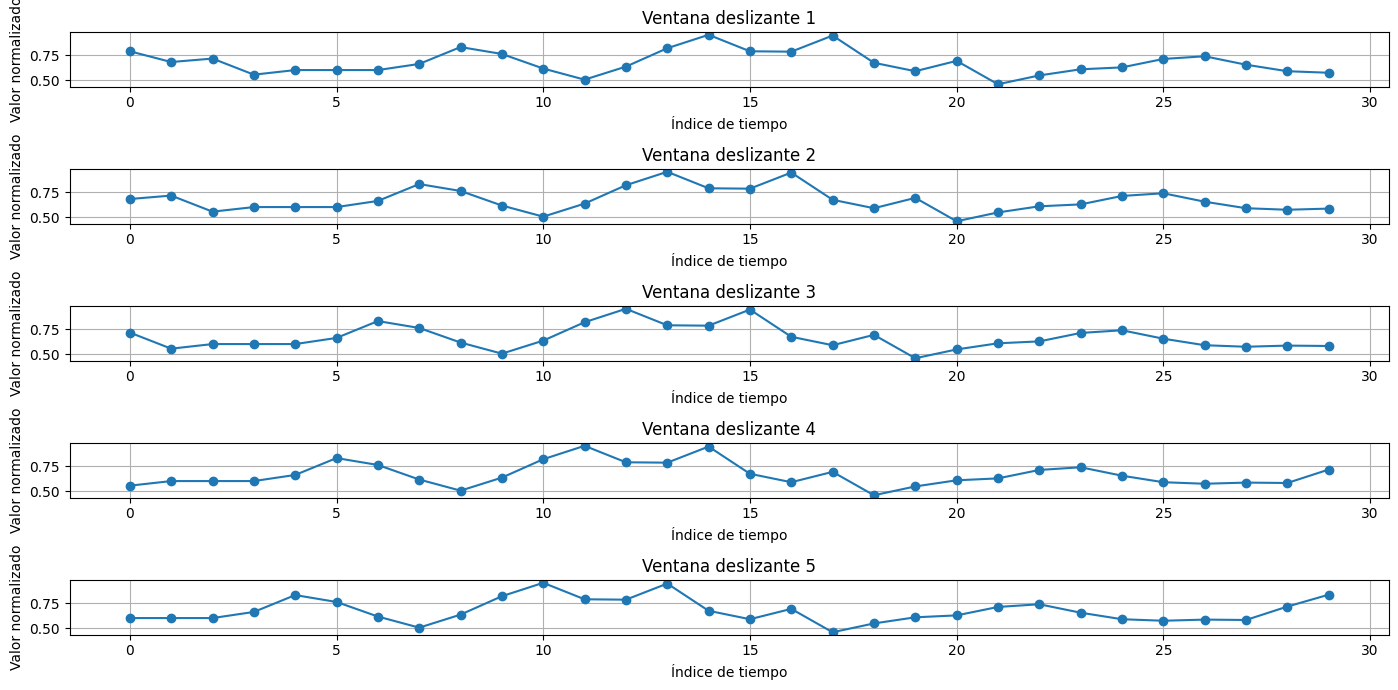

In [20]:
import matplotlib.pyplot as plt

# Número de ventanas a visualizar (por ejemplo, las primeras 5)
num_windows = 5

plt.figure(figsize=(14, 7))
for i in range(num_windows):
    plt.subplot(num_windows, 1, i+1)
    plt.plot(X[i], marker='o', linestyle='-')
    plt.title(f'Ventana deslizante {i+1}')
    plt.xlabel('Índice de tiempo')
    plt.ylabel('Valor normalizado')
    plt.grid(True)

plt.tight_layout()
plt.show()

Dificilmente se puede establecer una corrrelación temporal con la temperatura ... 

⚠️⚠️⚠️ Profesor, pregunta

**¿Esto puede entenderse cómo un fenómeno atravesado por la aleatoriedad o pseudoaleatoiredad?**

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 3. Diseño del modelo, entrenamiento y prueba

In [65]:
# Define tu modelo exactamente como lo tenías
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [71]:
# Función para entrenar el modelo
def train_model(model, X_train, Y_train, epochs=90, batch_size=32):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2)
    return history.history  # Devolver el historial como un diccionario

In [72]:
# Función predict_model sin cambios
def predict_model(model, X_test):
    predictions = model.predict(X_test)
    return predictions

### Explicación de la arquitectura del modelo

Se han generado tres tipos de funciones para diferenciar cada una de las fases de la arquitectura, de esta forma se invocan al momento de compilarlo. Como se puede observar las fucniones son las de creación, entrenamiento y prueba del modelo. La arquitectura del modelo sigue las indicaciones de la guía.

Algunas de las ventajas del modelo se pueden enumerar a continuación:

* Combinación de Convolucionales y LSTM: entiendo que la combinación de la convolucional y la LSTM en paralelo ayudan a distribuir las tareas del modelo. Mientras que la primera se encarga de encontrar los patrones en las series temporales, la segunda almacena los datos.

* Hiperparámetros para el análisis de información en series: strides=1, determinan cuántas unidades se desplaza el filtro a lo largo de la entrada, es decir, el filtro se mueve una unidad a la vez y esto permite que se analicen cada una de los datos de la serie. El padding, por su parte, permite que solo se analicen los datos del pasado.



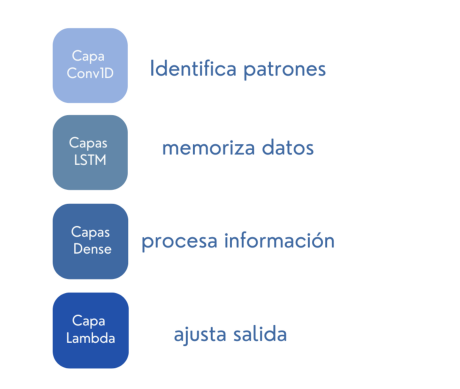

In [12]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Ruta del archivo PNG (ajústala según la ubicación de tu archivo)
#file_path = 'C:/Users/villa/Downloads/Dime, qué se siente haber leído un laudo más extenso al que te asignaron (37).png'

# Cargar la imagen
#img = imread(file_path)

# Mostrar la imagen
#plt.imshow(img)
#plt.axis('off')  # Ocultar ejes
#plt.show()

### Creación y prueba del modelo

In [73]:
# Crear el modelo y entrenarlo
model = build_model()
history = train_model(model, X_train, Y_train, epochs=90, batch_size=32)

Epoch 1/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.8910 - val_loss: 0.0252
Epoch 2/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0246 - val_loss: 0.0249
Epoch 3/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0235 - val_loss: 0.0246
Epoch 4/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0231 - val_loss: 0.0247
Epoch 5/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0235 - val_loss: 0.0264
Epoch 6/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0237 - val_loss: 0.0246
Epoch 7/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0220 - val_loss: 0.0246
Epoch 8/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0251 - val_loss: 0.0253
Epoch 9/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0239 - val_loss: 0.0262
Epoch 10/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0247 - val_loss: 0.0256
Epoch 11/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 12/90
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0

In [69]:
# Realizar predicciones
predictions = predict_model(model, X_test)
print(predictions)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[[[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]

 [[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]

 [[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]

 ...

 [[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]

 [[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]

 [[0.49546567]
  [0.49546567]
  [0.49546567]
  ...
  [0.49546567]
  [0.49546567]
  [0.49546567]]]


## 4. Gráficas y análisis 

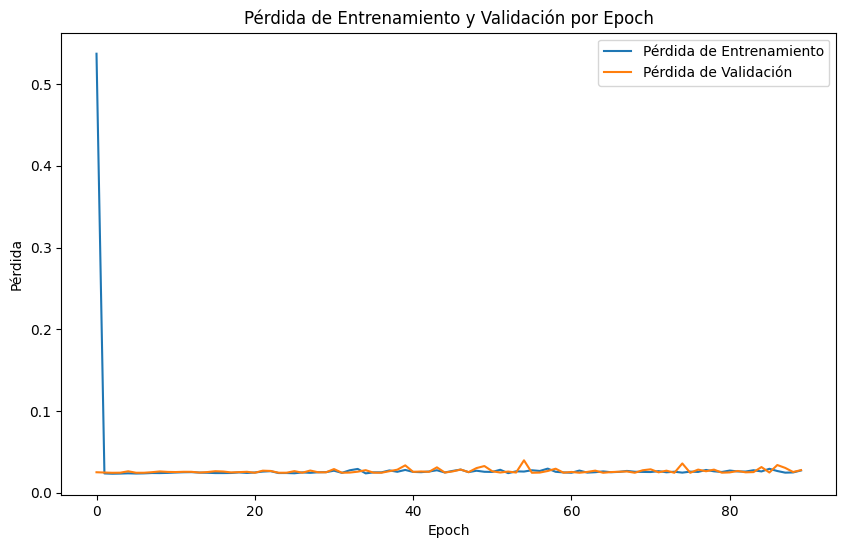

In [74]:
# Graficar pérdida de entrenamiento y validación por epoch
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de Validación')
plt.legend()
plt.title('Pérdida de Entrenamiento y Validación por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.show()

### ¿Qué tan rápido aprendió el modelo?

La gráfica compara las métricas de pérdida entre el entrenamiento y la prueba. Desde la primera época, se observa que el modelo aprende rápidamente y alcanza una estabilización hasta aproximadamente la época 40. Después de este punto, se nota un leve aumento en la pérdida del conjunto de prueba, indicando cierta fluctuación en el rendimiento del modelo, pero no lo bastante  como para sugerir un sobreajuste de los datos.

En este punto, decidí realizar un modelo alternativo con otra arquitectura de RNN debido a que el comportamiento de estos datos no me deja del todo satisfecha. En el notebook se presentan el diseño, ejecución y análisis de la segunda RNN.



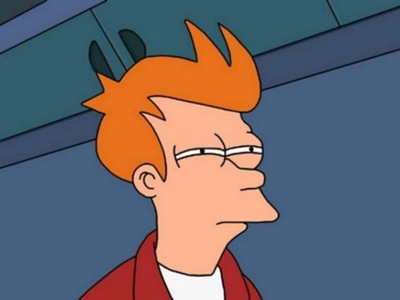

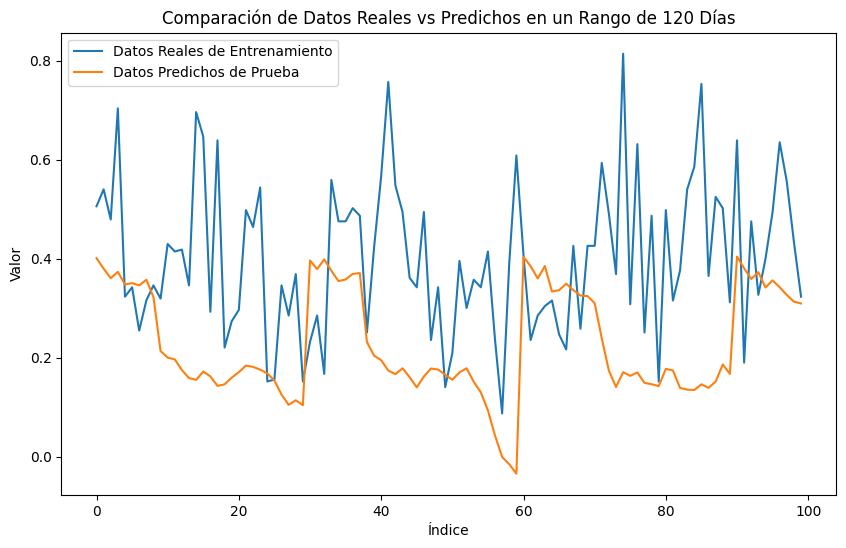

In [81]:
# Suponemos que Y_train y predictions tienen suficientes datos
rango_dias = 120
Y_train_120 = Y_train.flatten()[:rango_dias]
predictions_120 = predictions.flatten()[:rango_dias]

# Graficar datos reales vs datos predichos
plt.figure(figsize=(10, 6))
plt.plot(Y_train_100, label='Datos Reales de Entrenamiento')
plt.plot(predictions_100, label='Datos Predichos de Prueba')
plt.legend()
plt.title('Comparación de Datos Reales vs Predichos en un Rango de 120 Días')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()

⚠️⚠️⚠️

Al graficar los resultados de los valores reales frente a los valores predichos, se observa un rendimiento deficiente del modelo. Esto puede explicarse por las siguientes razones:

* Tesis 1: Es probable que no haya implementado correctamente la arquitectura de la red neuronal, lo que llevó al fracaso del modelo.

* Tesis 2: Se confirma la complejidad inherente de los datos de temperatura, dificultando el análisis de sus recurrencias y la identificación de patrones significativos para generar predicciones precisas.

* Tesis 3: Ajustar el número de épocas podría mejorar el modelo; considerar el uso de early stopping podría ser beneficioso para optimizar la técnica.

* Tesis 4: En este tipo de datos, una aproximación en lugar de una predicción exacta podría ser suficiente. Estos modelos podrían trabajar con una alta tolerancia al error, adaptándose mejor a la naturaleza variable de los datos de temperatura.
⚠️⚠️⚠️